# Introduction

In this Analysis we want to take dog breeds from posts on the WeRateDogs twitter handle and compare them with their ratings, number of retweets and number of favorites. Breeds were predicted from each of the post's images using a neural network. In order to do this analysis we have to gather the data from different sources and clean it up before displaying the findings.

# Gathering

In order to get our data in one place, first we need to get the orginal tweets data and image prediction data. Then we take additional tweet data right from the source by using Twitter's Python API Tweepy.

In [2]:
# Import Libraries and set column width for more readability
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tweepy
import time
import json
pd.set_option('display.max_colwidth', -1)


In [3]:
# Read the given data into DataFrame variables

tweets = pd.read_csv('twitter-archive-enhanced.csv')

images = pd.read_csv('image-predictions.tsv', sep='\t')

In [4]:
tweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [13]:
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [57]:
# Setup to access Twitter's API and set tweepy to parse data in Json format.

consumer_key = ""
consumer_secret = ""
access_token = ""
access_secret = ""


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                wait_on_rate_limit_notify = True)


In [58]:
# Gathers the data from Twitter and writes into a file in Json format.

start_time = time.time()

with open('tweet_json.txt', 'w') as file:
    for tweet_id in tweets['tweet_id']:
        try:
            tweet = api.get_status(tweet_id,tweet_mode='extended')
            file.write( json.dumps(tweet) + '\n' )
        except Exception as e:
            print('No tweet found for {} wit error message {}'.format(str(tweet_id), str(e)))

end_time = time.time()

print('Whole process finished in {} seconds'.format(end_time - start_time))

No tweet found for 888202515573088257 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 873697596434513921 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 872668790621863937 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 872261713294495745 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 869988702071779329 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 866816280283807744 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 861769973181624320 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 856602993587888130 wit error message [{'code': 144, 'message': 'No status found with that ID.'}]
No tweet found for 851953902622658560 wit error message [{'code': 144, '

In [59]:
# Reads Json data, appends desired variables to a list, and turns that list into a DataFrame.

selected_vars = []

with open('tweet_json.txt', 'r') as file:
    for line in file:
        json_data = json.loads(line)
        selected_vars.append({'tweet_id' : json_data['id'],
                              'favorites' : json_data['favorite_count'],
                              'retweets' : json_data['retweet_count'],
                              'timestamp' : json_data['created_at']})
        
extra_vars = pd.DataFrame(selected_vars, columns=['tweet_id', 'favorites', 'retweets', 'timestamp'])

In [60]:
extra_vars


,tweet_id,favorites,retweets,timestamp
0,892420643555336193,35146,7410,Tue Aug 01 16:23:56 +0000 2017
1,892177421306343426,30413,5515,Tue Aug 01 00:17:27 +0000 2017
2,891815181378084864,22862,3640,Mon Jul 31 00:18:03 +0000 2017
3,891689557279858688,38421,7589,Sun Jul 30 15:58:51 +0000 2017
4,891327558926688256,36674,8163,Sat Jul 29 16:00:24 +0000 2017
5,891087950875897856,18492,2740,Sat Jul 29 00:08:17 +0000 2017
6,890971913173991426,10752,1771,Fri Jul 28 16:27:12 +0000 2017
7,890729181411237888,59178,16583,Fri Jul 28 00:22:40 +0000 2017
8,890609185150312448,25447,3788,Thu Jul 27 16:25:51 +0000 2017
9,890240255349198849,29055,6426,Wed Jul 26 15:59:51 +0000 2017


# Initial Exploration

Here we explore the variables in the data to make a list of things we will need to clean for the analysis.

## Master Tweet Data Set

### Checking for Nulls, Duplicates, and Data Types

In [61]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

We will certainly want to fix the tweet_id and make it into an object.

In [62]:
tweets.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          0   
doggo                         0   
floofer                       0   
pupper                        0   
puppo                         0   
dtype: int64

Nulls in replys and retweets are most of of the data set. This means that it only consists of a small amount of retweets and replys and that it will be easy to drop those rows.

In [63]:
tweets['tweet_id'].duplicated().any()

False

No duplicate tweet ids to worry about.

### Looking at Ratings

In [64]:
tweets['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

Most of the rating denominators are in fact 10.

In [65]:
tweets['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

There is only a small number above 14.

In [66]:
tweets[tweets['rating_numerator'] > 14]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
285,838916489579200512,NaN,NaN,2017-03-07 00:57:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI,8.389060e+17,8.117408e+08,2017-03-07 00:15:46 +0000,"https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1",15,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None


We see that there are a few that are not correct and show up as decimals. We will see this again after we drop rows and the denominator column later on.

### Looking at Dog Names

In [67]:
tweets['name'].value_counts() 

None        745
a           55 
Charlie     12 
Cooper      11 
Lucy        11 
Oliver      11 
Tucker      10 
Lola        10 
Penny       10 
Winston     9  
Bo          9  
Sadie       8  
the         8  
Toby        7  
Daisy       7  
Bailey      7  
Buddy       7  
an          7  
Leo         6  
Scout       6  
Bella       6  
Dave        6  
Oscar       6  
Rusty       6  
Stanley     6  
Koda        6  
Milo        6  
Jax         6  
Jack        6  
Larry       5  
           ..  
Remy        1  
Obi         1  
Cheesy      1  
Bruno       1  
Fido        1  
Emanuel     1  
Jerome      1  
Jim         1  
Frönq       1  
Rumble      1  
Trevith     1  
Ralphé      1  
Aja         1  
Clyde       1  
Ralph       1  
Ruffles     1  
Fynn        1  
Covach      1  
Jeffrie     1  
Berkeley    1  
Sid         1  
Shooter     1  
Jameson     1  
Tassy       1  
Snickers    1  
Snoopy      1  
Oddie       1  
River       1  
Pawnd       1  
Nimbus      1  
Name: name, Length: 957,

Most of the dog names are "None". The ones that are not actual names seem to be ones without a capital letter.

## Checking for Nulls, Duplicates, and Data Types in the other data sets

In [68]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [69]:
images.isnull().any()

tweet_id    False
jpg_url     False
img_num     False
p1          False
p1_conf     False
p1_dog      False
p2          False
p2_conf     False
p2_dog      False
p3          False
p3_conf     False
p3_dog      False
dtype: bool

In [70]:
images.duplicated().any()

False

In [71]:
extra_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 4 columns):
tweet_id     2331 non-null int64
favorites    2331 non-null int64
retweets     2331 non-null int64
timestamp    2331 non-null object
dtypes: int64(3), object(1)
memory usage: 72.9+ KB


In [72]:
extra_vars.duplicated().any()

False

Luckily, there are no nulls, or duplicates of any kind to worry about in the image prediction and extra variable datasets. We will however, make sure to change the data type of tweet ids on both of them, as well as the master data set in order to join them.

# Asessing The Data

## Tidyness Issues

1. We need to first merge the extra tweet information (favorites and retweets) to the main dataframe.

2. Then we need to add the dog breed predictions as well.

## Quality Issues

1. Tweet_id on all the files should be made into string a object instead of an integer.

2. Set timestamp column in the master dataframe to datetime format and the rating numerator data type should be changed to a float to incorporate decimal ratings.

3. In the image prediction dataframe we will drop the other 2 predictions and just go with the top prediction.


4. We must drop rows that are retweets or replys because we only want to see original tweets.

5. We must fix the names of dogs because there are errors.

6. Ratings should be put in a different format to be used in the analysis, since they almost all have a denominator of 10, the denominator column can be dropped afterward.

7. There are errors in three ratings above 14 that are actually decimal ratings in the text. 


8. Dog "Stage" will be dropped because there are not enough rows to do a meaningful analysis and it would be very difficult to extract that data from the text because there are many words to describe dog "stages".

# Cleaning

In [73]:
# Make copies of the dataframes.

clean_tweets = tweets.copy()
clean_images = images.copy()
clean_extra_vars = extra_vars.copy()

## First Quality Issues


### Changing Tweet ID Data Types

First thing to do is to put all the tweet_id columns of all the data sources to a string object data type to ensure that they can be used as a join key when merging the data sets.

In [74]:
clean_tweets['tweet_id'] = tweets['tweet_id'].astype('object')
clean_images['tweet_id'] = images['tweet_id'].astype('object')
clean_extra_vars['tweet_id'] = extra_vars['tweet_id'].astype('object')

### Fixing Time Stamps

Changing the the data type of the timestamp column to datetime format.

In [75]:
clean_tweets['timestamp'] = tweets['timestamp'].astype('datetime64[ns]')

### Changing Numerator to Float Datatype

This ensures later on that we will be able to include decimal data into the column.

In [76]:
clean_tweets['rating_numerator'] = clean_tweets['rating_numerator'].astype('float64')

### Getting Best Breed Predictions

Here we want to take the best confidence score out of all three algorthimns to get the most likely dog breed prediction. Since they are ordered by top 3 predictions then we will just take the first ones.

In [77]:
clean_images = clean_images[['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog']]

## Tidyness Issues

### Merging Extra Tweet Variables

Now that the data sets are ready for joining we first add the retweet and favorite counts from the data gathered on twitter's API using the twitter id as the unique key. We will quickly drop the timestamp column on the extra variables data because we do not want a duplicate column.

In [78]:
clean_extra_vars.drop(columns='timestamp', inplace=True)

clean_tweets = clean_tweets.merge(clean_extra_vars, on='tweet_id')

### Merging Dog Breed Predictions

We will also merge our dog breed predictions using the same method and rename the the p1 column to breed.

In [79]:
clean_tweets = clean_tweets.merge(clean_images, on='tweet_id')

# Column rename to breed.
clean_tweets.rename(columns={'p1' : 'breed'},inplace=True)

## More Quality Issues


### Dropping Retweets and Replys

Now that we have all our data in one place, we will drop any rows, that are retweets or replys since we only want to analyse original tweets.

In [80]:
clean_tweets = clean_tweets[clean_tweets['in_reply_to_status_id'].isnull()]

clean_tweets = clean_tweets[clean_tweets['retweeted_status_id'].isnull()]

### Dropping Unused Columns

We drop a bunch of columns that have no use the analysis.

In [81]:
clean_tweets.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id', 'source','retweeted_status_id',
                           'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls'], inplace=True)

### Fixing Dog Names

In [82]:
clean_tweets['name'].value_counts()

None        524
a           55 
Cooper      10 
Oliver      10 
Charlie     10 
Tucker      9  
Penny       9  
Lucy        9  
Sadie       8  
Winston     8  
the         7  
Toby        7  
Daisy       7  
Lola        7  
Jax         6  
Bella       6  
an          6  
Bo          6  
Stanley     6  
Koda        6  
Buddy       5  
Milo        5  
Rusty       5  
Scout       5  
Chester     5  
Oscar       5  
Dave        5  
Louis       5  
Bailey      5  
Leo         5  
           ..  
Snoopy      1  
Gin         1  
Shiloh      1  
Pawnd       1  
Ralphé      1  
Trevith     1  
Rumble      1  
Anna        1  
Crawford    1  
space       1  
Tonks       1  
Lilli       1  
Pip         1  
Jomathan    1  
Rueben      1  
Moreton     1  
Socks       1  
Jimbo       1  
Darla       1  
Davey       1  
Nida        1  
Ulysses     1  
Maisey      1  
Rolf        1  
Bertson     1  
Jonah       1  
Sandra      1  
Pippin      1  
Liam        1  
Nimbus      1  
Name: name, Length: 933,

The way we locate any name errors is by querying for only lowercase names and changing them to "None".

In [83]:
# Put all the lowercase names into one variable.
name_errors = clean_tweets['name'].str.islower()

# Change all of them to "None"
clean_tweets.loc[name_errors, 'name'] = 'None'

# Check to make sure it worked.
clean_tweets.name.value_counts()

None        622
Cooper      10 
Charlie     10 
Oliver      10 
Lucy        9  
Tucker      9  
Penny       9  
Winston     8  
Sadie       8  
Toby        7  
Daisy       7  
Lola        7  
Bella       6  
Bo          6  
Jax         6  
Stanley     6  
Koda        6  
Oscar       5  
Chester     5  
Buddy       5  
Scout       5  
Rusty       5  
Dave        5  
Leo         5  
Louis       5  
Milo        5  
Bailey      5  
Brody       4  
Gary        4  
Clark       4  
           ..  
Kramer      1  
Barney      1  
Henry       1  
Creg        1  
Stormy      1  
Superpup    1  
Mary        1  
Maya        1  
Holly       1  
Cannon      1  
Emmy        1  
Apollo      1  
Banditt     1  
Derby       1  
Kara        1  
Tove        1  
Lulu        1  
Fletcher    1  
Traviss     1  
Terrance    1  
Fiji        1  
Brady       1  
Mollie      1  
Gromit      1  
Tupawc      1  
Cilantro    1  
O           1  
Kayla       1  
Margo       1  
Berkeley    1  
Name: name, Length: 911,

## Fixing Ratings

Dog ratings have irregular ratings for a few of them and some are errors. The simpliest way to resolve this is to drop the denominator column because this twitter handle for the most part uses a denominator of 10 for it's ratings. We can keep this as a constant and deal with only the numerator column.

In [84]:
clean_tweets['rating_denominator'].value_counts()

10     1947
50     3   
80     2   
11     2   
170    1   
150    1   
120    1   
110    1   
90     1   
70     1   
40     1   
20     1   
7      1   
2      1   
Name: rating_denominator, dtype: int64



We see that only a handful are not 10 so we will first delete this rows completely.

In [85]:
# Take all the ratings that are not equal to ten.
bad_ratings = clean_tweets['rating_denominator'] != 10

# Get the index of those ratings and drop by index.
clean_tweets.drop(index= clean_tweets.loc[bad_ratings].index, inplace=True)

Then we will drop the column.

In [86]:
clean_tweets.drop(columns = 'rating_denominator', inplace=True)

Next we will work with the numerator column.

In [87]:
clean_tweets['rating_numerator'].value_counts()

12.0      444
10.0      416
11.0      392
13.0      249
9.0       149
8.0       95 
7.0       51 
14.0      33 
5.0       33 
6.0       32 
3.0       19 
4.0       15 
2.0       9  
1.0       4  
27.0      1  
0.0       1  
1776.0    1  
26.0      1  
75.0      1  
420.0     1  
Name: rating_numerator, dtype: int64

Again, we see that only a small number is well above a 14 out of 10.

In [88]:
# Get a dataframe of only the records with a rating above 14 and look through the text column.
clean_tweets[clean_tweets['rating_numerator'] > 14]

,tweet_id,timestamp,text,rating_numerator,name,doggo,floofer,pupper,puppo,favorites,retweets,jpg_url,img_num,breed,p1_conf,p1_dog
548,786709082849828864,2016-10-13 23:23:56,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0,Logan,None,None,None,None,18046,6024,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1,Pomeranian,0.467321,True
603,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0,Sophie,None,None,pupper,None,6446,1570,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1,clumber,0.946718,True
789,749981277374128128,2016-07-04 15:00:45,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0,Atticus,None,None,None,None,4956,2390,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,1,bow_tie,0.533941,False
1438,680494726643068929,2015-12-25 21:06:00,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0,None,None,None,None,None,1659,467,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,1,kuvasz,0.438627,True
1781,670842764863651840,2015-11-29 05:52:33,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420.0,None,None,None,None,None,23014,8005,https://pbs.twimg.com/media/CU9P717W4AAOlKx.jpg,1,microphone,0.096063,False


We see here that we need to change row 548 to 9.75, row 603 to 11.27, and row 1438 to 11.26

In [89]:
clean_tweets['rating_numerator'].loc[548] = 9.75
clean_tweets['rating_numerator'].loc[603] = 11.27
clean_tweets['rating_numerator'].loc[1438] = 11.26

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [90]:
# Renaming the column to rating

clean_tweets.rename(columns={'rating_numerator' : 'rating'}, inplace=True)

There could defintely be more errors in the rest of the ratings however, there are too many rows with ratings below 14 to assess them all manually. we did ensure that we fixed any outliers for huge ratings that could be accounted for in the ratings column. Lastly, we changed the column name for better readability.

### Fixing Dog Stages

First we print out all the instances of doggo, floofer, pupper, and pupper in our master dataframe text column.

In [91]:
print('Count of doggo contained in text column:')
print(clean_tweets['text'].str.contains('doggo').value_counts(), '\n')

print('Count of floofer contained in text column:')
print(clean_tweets['text'].str.contains('floofer').value_counts(), '\n')

print('Count of pupper contained in text column:')
print(clean_tweets['text'].str.contains('pupper').value_counts(), '\n')

print('Count of puppo contained in text column:')
print(clean_tweets['text'].str.contains('puppo').value_counts(), '\n')

Count of doggo contained in text column:
False    1874
True     73  
Name: text, dtype: int64 

Count of floofer contained in text column:
False    1944
True     3   
Name: text, dtype: int64 

Count of pupper contained in text column:
False    1727
True     220 
Name: text, dtype: int64 

Count of puppo contained in text column:
False    1920
True     27  
Name: text, dtype: int64 



Considering that all of these dog "stage" nicknames are only mentioned in a small amount of text rows and that in the doggo world, people have many more ways to describe these "stages", they will be excluded, and dropped from the analysis.

In [92]:
clean_tweets.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

### Putting Clean Master File to CSV

In [93]:
clean_tweets.to_csv('twitter_archive_master.csv')

# Analysis

Finally we get to the fun part! We are going to find out which dog breeds had the best ratings overall and which breeds had the most favorites and the most retweets. Keep in mind that the breeds listed for each picture were predicted with a neural network that was not perfect and probably has some errors. We are using this because it is our best way of guessing what breeds the dogs were in the tweets.

For Breed counts, retweet averages, and favorite averages, the top 10 largest are chosen because showing all 111 dog breeds in a graph would be rather cumbersome. Top 20 are chosen for rating because all ratings are so close together.

## What Breeds Had the Best Ratings?

### Exploring Breeds

In [3]:
df = pd.read_csv('twitter_archive_master.csv')

# Get dogs only
dog_breed_tweets = df[df['p1_dog'] == True]

In [108]:
dog_breed_tweets['breed'].nunique()

111

In [95]:
dog_breed_tweets['breed'].value_counts().nlargest(10)

golden_retriever      134
Labrador_retriever    89 
Pembroke              88 
Chihuahua             78 
pug                   54 
chow                  41 
Samoyed               39 
Pomeranian            38 
toy_poodle            36 
malamute              29 
Name: breed, dtype: int64

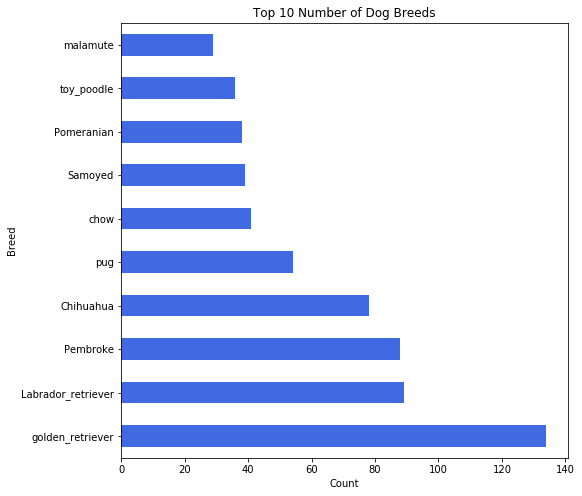

In [15]:
plt.figure(figsize=(8,8))
plt.title('Top 10 Number of Dog Breeds')
plt.xlabel('Count')
plt.ylabel('Breed')

dog_breed_tweets['breed'].value_counts().nlargest(10).plot(kind='barh', color='royalblue');

The most common breed in our sample is the Golden Retrieverwith a count of 134 followed by Labrador Retriever with a count of 89.

In [97]:
dog_breed_tweets.groupby('breed').rating.mean().nlargest(20)

breed
Saluki                        12.500000
briard                        12.333333
Tibetan_mastiff               12.250000
Border_terrier                12.142857
silky_terrier                 12.000000
standard_schnauzer            12.000000
Eskimo_dog                    11.777778
Gordon_setter                 11.750000
Irish_setter                  11.750000
Samoyed                       11.743590
chow                          11.609756
golden_retriever              11.567164
Cardigan                      11.529412
Australian_terrier            11.500000
giant_schnauzer               11.500000
wire-haired_fox_terrier       11.500000
Great_Pyrenees                11.461538
kelpie                        11.454545
Pembroke                      11.443182
Greater_Swiss_Mountain_dog    11.333333
Name: rating, dtype: float64

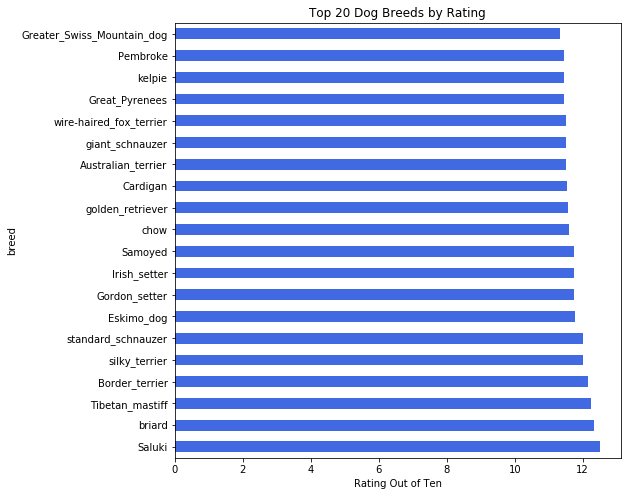

In [12]:
plt.figure(figsize=(8,8))
plt.title('Top 20 Dog Breeds by Rating')
plt.xlabel('Rating Out of Ten')

dog_breed_tweets.groupby('breed').rating.mean().nlargest(20).plot(kind='barh', color='royalblue');

The most Top rated dog is the Saluki with a mean rating of 12.5.

In the top 20 Breeds of dogs, the rating does not seem to differ too much. Only by 1-2 points. It seems that the owner of WeRateDogs rates dogs mostly around 12-14 out of 10 no matter what the breed of dog is.

## What Breeds Had The Most Retweets?

In [99]:
dog_breed_tweets.groupby('breed').retweets.mean().nlargest(10)

breed
standard_poodle          5681.857143
English_springer         5114.333333
Afghan_hound             5030.333333
Eskimo_dog               4650.666667
Saluki                   4350.000000
giant_schnauzer          4339.000000
Great_Pyrenees           4201.538462
French_bulldog           4131.520000
Lakeland_terrier         4064.066667
flat-coated_retriever    3899.250000
Name: retweets, dtype: float64

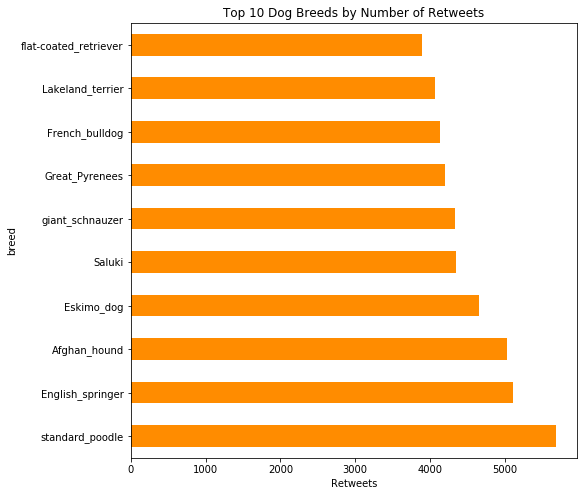

In [13]:
plt.figure(figsize=(8,8))
plt.title('Top 10 Dog Breeds by Number of Retweets')
plt.xlabel('Retweets')
plt.ylabel('Breed')

dog_breed_tweets.groupby('breed').retweets.mean().nlargest(10).plot(kind='barh', color='darkorange');

The most retweeted dog by far is the standard poodle breed with a mean number 5681.86 of retweets.

## What Breeds had The Most Favorites?

In [101]:
dog_breed_tweets.groupby('breed').favorites.mean().nlargest(10)

breed
Saluki                     21611.250000
French_bulldog             16986.680000
Afghan_hound               15304.000000
giant_schnauzer            15293.500000
black-and-tan_coonhound    15218.000000
flat-coated_retriever      15071.250000
Irish_water_spaniel        14540.666667
standard_poodle            14155.857143
English_springer           13980.555556
Cardigan                   13580.352941
Name: favorites, dtype: float64

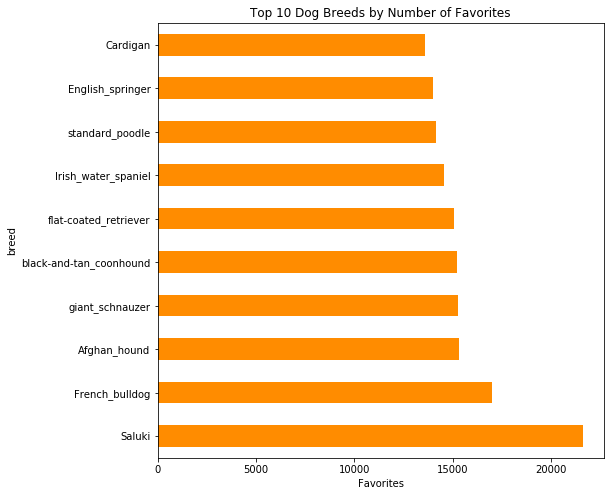

In [14]:
plt.figure(figsize=(8,8))
plt.title('Top 10 Dog Breeds by Number of Favorites')
plt.xlabel('Favorites')
plt.ylabel('Breed')

dog_breed_tweets.groupby('breed').favorites.mean().nlargest(10).plot(kind='barh', color='darkorange');

Saluki again is also the top favorited breed of dog in our dataset with a mean of 21611.25 of favorites.

# Limitations

After dropping rows, and cleaning the data, we were only left with 1,947 rows to work with. This analysis could potentially be improved by getting a bigger sample and getting all of the tweets directly using Tweepy. Further, someone with better text extracting capabilities may be able to write scripts to get more rating data, dog name data, and even possibly more dog "stage" data that could be used in an analysis. Lastly, a neural network with more accuracy predicting dog breeds could also possibly give us better results

# Conclusion

After gathering, assessing, and cleaning all our data, we were able to gain some insights from this data. We found that the most common dog breed to be posted on WeRateDogs was the Golden Retriever with a count of 134. That makes sense because they are very popular friendly family dogs and they are also used often as mental health therapy dogs. 

Even though the Saluki breed had the highest overall ratings with a mean of 12.5, it seems that that the author of WeRateDogs seems to rate all the dogs between 12 and 14 over 10 no matter what the breed is. This is most likely part of what makes the twitter handle so popular because many dog lovers love all dogs.

The Breed with the highest number of retweets was the standard poodle with a mean of 5681.86 retweets. This also makes sense because poodles are not only very popular dog breeds, but they also take funny pictures.

Lastly we looked at breeds with the most number of favorites. Saluki again came in first place with a mean of 21,611.25 favorites. It seems that Saluki's may be a very popular dog on this twitter handle considering they came out on top in two different categories.
